# Multiclass Text Classification


> Model mengklasifikasi berita ke dalam lima kategori, yaitu **sport, business, politics, tech and entertainment**

> Dataset diperoleh dari https://www.kaggle.com/yufengdev/bbc-fulltext-and-category


In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [5]:
!pip install kaggle
!kaggle datasets download -d yufengdev/bbc-fulltext-and-category

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 67.6MB/s]


In [6]:
!unzip /content/bbc-fulltext-and-category.zip -d "/content/drive/MyDrive/Colab Notebooks"

Archive:  /content/bbc-fulltext-and-category.zip
  inflating: /content/drive/MyDrive/Colab Notebooks/bbc-text.csv  


In [8]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bbc-text.csv')
df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [9]:
category = pd.get_dummies(df.category)
category

,business,entertainment,politics,sport,tech
0,0,0,0,0,1
1,1,0,0,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0
...,...,...,...,...,...
2220,1,0,0,0,0
2221,0,0,1,0,0
2222,0,1,0,0,0
2223,0,0,1,0,0


In [10]:
new_df = pd.concat([df, category], axis=1)
new_df = new_df.drop(columns=['category'])
new_df.head(10)

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
5,howard hits back at mongrel jibe michael howar...,0,0,1,0,0
6,blair prepares to name poll date tony blair is...,0,0,1,0,0
7,henman hopes ended in dubai third seed tim hen...,0,0,0,1,0
8,wilkinson fit to face edinburgh england captai...,0,0,0,1,0
9,last star wars not for children the sixth an...,0,1,0,0,0


In [11]:
text = new_df['text'].values
text

array(['tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in 

In [12]:
categ = new_df[['business', 'entertainment', 'politics', 'sport', 'tech']].values
categ

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [13]:
from sklearn.model_selection import train_test_split
text_train, text_test, cat_train, cat_test = train_test_split(text, categ, test_size=0.2)

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

padded_train = pad_sequences(seq_train)
padded_test = pad_sequences(seq_test)

In [16]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [17]:
class callbackModel(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.8 and logs.get('val_accuracy')>0.8):
      print("\nAkurasi telah mencapai >80%!")
      self.model.stop_training = True
callbacks = callbackModel()

In [18]:
hist = model.fit(padded_train, 
                 cat_train, 
                 batch_size=128, 
                 epochs=30, 
                 validation_data=(padded_test, cat_test), 
                 verbose=2,
                 callbacks=[callbacks])

Epoch 1/30
14/14 - 78s - loss: 1.6079 - accuracy: 0.2303 - val_loss: 1.6073 - val_accuracy: 0.2472
Epoch 2/30
14/14 - 74s - loss: 1.6065 - accuracy: 0.2264 - val_loss: 1.6057 - val_accuracy: 0.2652
Epoch 3/30
14/14 - 75s - loss: 1.6024 - accuracy: 0.2483 - val_loss: 1.6038 - val_accuracy: 0.2292
Epoch 4/30
14/14 - 75s - loss: 1.5980 - accuracy: 0.2275 - val_loss: 1.5956 - val_accuracy: 0.2787
Epoch 5/30
14/14 - 75s - loss: 1.6790 - accuracy: 0.2326 - val_loss: 1.5969 - val_accuracy: 0.2517
Epoch 6/30
14/14 - 75s - loss: 1.5808 - accuracy: 0.2927 - val_loss: 1.5845 - val_accuracy: 0.2899
Epoch 7/30
14/14 - 74s - loss: 1.5472 - accuracy: 0.3556 - val_loss: 1.5485 - val_accuracy: 0.3730
Epoch 8/30
14/14 - 74s - loss: 1.4606 - accuracy: 0.4315 - val_loss: 1.4509 - val_accuracy: 0.3955
Epoch 9/30
14/14 - 74s - loss: 1.2778 - accuracy: 0.4601 - val_loss: 1.1742 - val_accuracy: 0.4787
Epoch 10/30
14/14 - 75s - loss: 1.1165 - accuracy: 0.5506 - val_loss: 1.2786 - val_accuracy: 0.3955
Epoch 11/

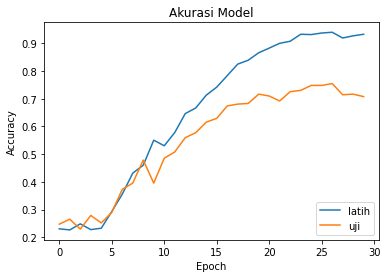

In [19]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['latih', 'uji'], loc='lower right')
plt.show()

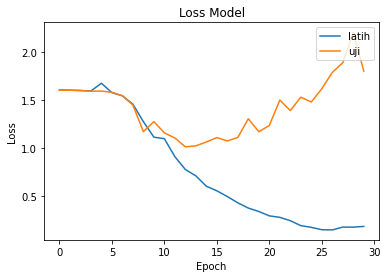

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['latih', 'uji'], loc='upper right')
plt.show()

In [21]:
hist = model.fit(padded_train, 
                 cat_train, 
                 batch_size=128, 
                 epochs=20, 
                 validation_data=(padded_test, cat_test), 
                 verbose=2,
                 callbacks=[callbacks])

Epoch 1/20
14/14 - 74s - loss: 0.1505 - accuracy: 0.9472 - val_loss: 1.8482 - val_accuracy: 0.7303
Epoch 2/20
14/14 - 74s - loss: 0.1243 - accuracy: 0.9551 - val_loss: 2.0239 - val_accuracy: 0.7281
Epoch 3/20
14/14 - 74s - loss: 0.1174 - accuracy: 0.9511 - val_loss: 2.0901 - val_accuracy: 0.7101
Epoch 4/20
14/14 - 74s - loss: 0.1120 - accuracy: 0.9534 - val_loss: 2.0705 - val_accuracy: 0.7236
Epoch 5/20
14/14 - 74s - loss: 0.1016 - accuracy: 0.9567 - val_loss: 2.1731 - val_accuracy: 0.7371
Epoch 6/20
14/14 - 74s - loss: 0.0915 - accuracy: 0.9635 - val_loss: 2.2749 - val_accuracy: 0.7281
Epoch 7/20
14/14 - 74s - loss: 0.0882 - accuracy: 0.9573 - val_loss: 2.2737 - val_accuracy: 0.7506
Epoch 8/20
14/14 - 74s - loss: 0.1004 - accuracy: 0.9562 - val_loss: 2.4812 - val_accuracy: 0.7371
Epoch 9/20
14/14 - 74s - loss: 0.0854 - accuracy: 0.9601 - val_loss: 2.3474 - val_accuracy: 0.7573
Epoch 10/20
14/14 - 73s - loss: 0.0837 - accuracy: 0.9624 - val_loss: 2.4586 - val_accuracy: 0.7528
Epoch 11/

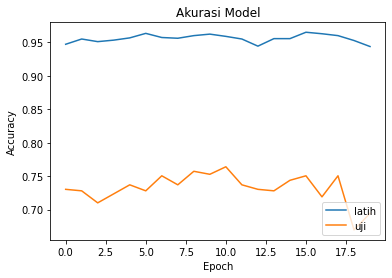

In [22]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['latih', 'uji'], loc='lower right')
plt.show()

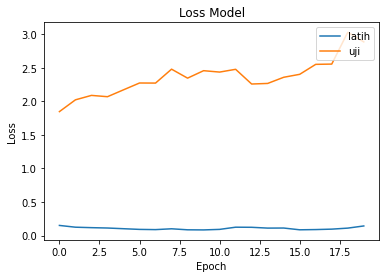

In [23]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['latih', 'uji'], loc='upper right')
plt.show()